In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split as tts
from sklearn.ensemble import ExtraTreesClassifier as ExTC
#from pprint import pprint
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
R2 = pd.read_csv('./surrogate_performance/R^2.csv', index_col=0)
features = pd.read_csv('./features/benchmark.csv', index_col=0)

In [3]:
cv_max = pd.read_csv('./surrogate_performance/benchmarkCV-score-max.csv', index_col=0)
cv_mean = pd.read_csv('./surrogate_performance/benchmarkCV-score-mean.csv', index_col=0)

In [4]:
# Drop NANs
features.dropna(axis = 1, inplace=True)

In [5]:
# Drop columns with only one unique value
cols = features.select_dtypes([np.number]).columns
std = features[cols].std()
cols_to_drop = std[std==0].index
features = features.drop(cols_to_drop, axis=1)

In [6]:
# Drop columns with inf
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(axis = 1, inplace=True)

In [7]:
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
loss = -R2.sub(R2.max(axis=1), axis=0)
targets = loss.idxmin(axis=1)

In [8]:
# Getting data that is avalable in both targets and features
features_available_for = targets.index.intersection(features.index)
targets = targets.loc[features_available_for]

In [9]:
# Doing the same for cv_max and cv_mean

cv_max = cv_max.loc[features_available_for]
cv_mean = cv_mean.loc[features_available_for]
cv_mean_best = cv_mean.idxmax(axis=1)
cv_max_best = cv_max.idxmax(axis=1)

In [10]:
# Train test split
train_features, test_features, train_targets, test_targets = tts(features, targets)

In [11]:
# Training the selector
selector = ExTC()
selector.fit(train_features.values, train_targets.values)

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
                     max_depth=None, max_features='auto', max_leaf_nodes=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
                     oob_score=False, random_state=None, verbose=0,
                     warm_start=False)

In [12]:
predicted_targets = selector.predict(test_features)
predicted_targets = pd.DataFrame(predicted_targets, index=test_features.index, columns=['Prediction'])

<IPython.core.display.Javascript object>


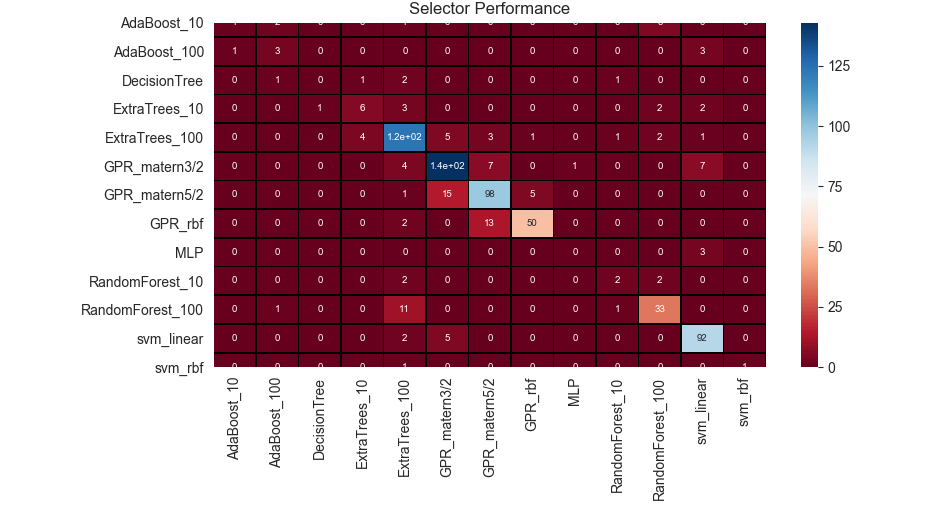

Text(0.5, 1, 'Selector Performance')

In [13]:
con_mat = metrics.confusion_matrix(test_targets, predicted_targets)
con_mat = pd.DataFrame(con_mat, index=selector.classes_, columns= selector.classes_)
sns.set_style("whitegrid")
sns.heatmap(con_mat,cmap="RdBu",annot=True,annot_kws={"size": 7},linewidths=0.5, linecolor='black')
plt.tight_layout()
plt.title('Selector Performance')

In [14]:
# For loss comparison
comparison_index = loss.index.intersection(predicted_targets.index)
loss_compare = loss.loc[comparison_index]
loss_prediction = pd.DataFrame(columns=['Prediction'], index=comparison_index, dtype=float)

In [15]:
for comp_id in comparison_index:
    loss_prediction['Prediction'].at[comp_id] = loss_compare[predicted_targets.loc[comp_id]].loc[comp_id]

In [16]:
loss_compare.sort_index(axis=1, inplace=True)
loss_compare = loss_compare.join(loss_prediction)

<IPython.core.display.Javascript object>


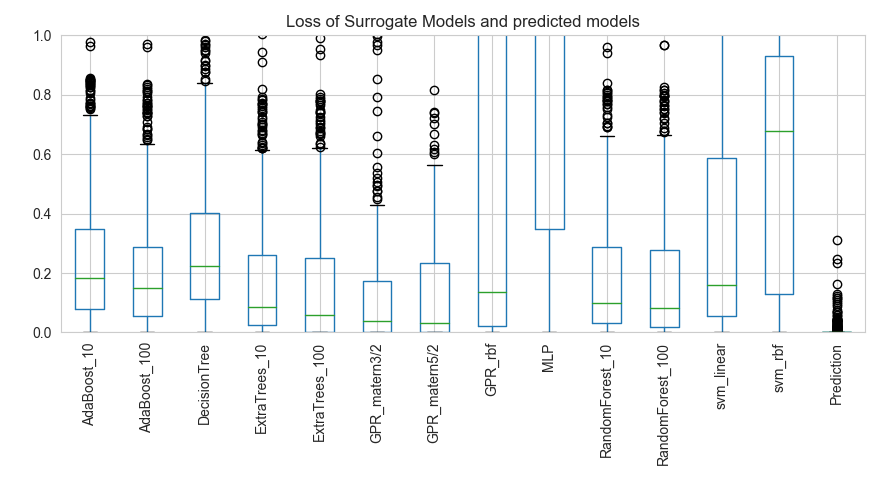

Prediction    0.030176
Name: 0.95, dtype: float64

In [17]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [18]:
# Direct Prediction with CV Values
loss_predictionCVmax = pd.DataFrame(columns=['CVmax'], index=comparison_index, dtype=float)
for comp_id in comparison_index:
    loss_predictionCVmax['CVmax'].at[comp_id] = loss_compare[cv_max_best.loc[comp_id]].loc[comp_id]

    
loss_predictionCVmean = pd.DataFrame(columns=['CVmean'], index=comparison_index, dtype=float)
for comp_id in comparison_index:
    loss_predictionCVmean['CVmean'].at[comp_id] = loss_compare[cv_mean_best.loc[comp_id]].loc[comp_id]

In [19]:
loss_compare = loss_compare.join(loss_predictionCVmax)
loss_compare = loss_compare.join(loss_predictionCVmean)

<IPython.core.display.Javascript object>


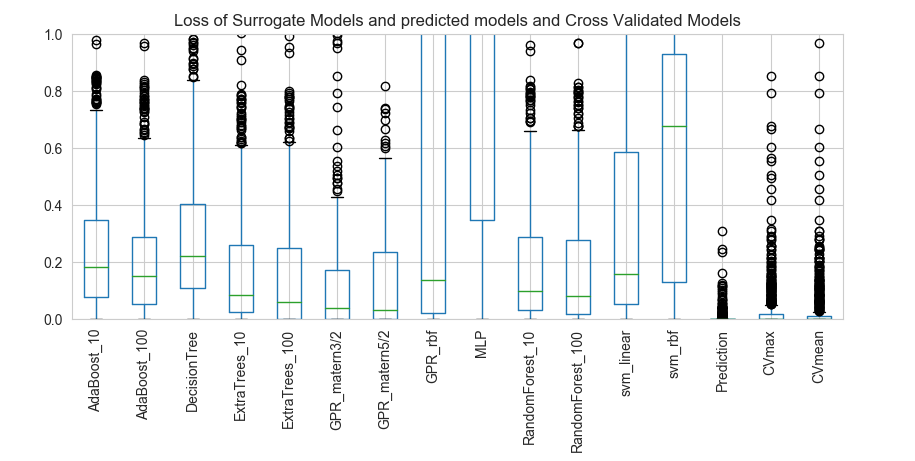

Prediction    0.030176
Name: 0.95, dtype: float64

In [20]:
loss_chart = loss_compare.boxplot(rot=90)
loss_chart.set_title('Loss of Surrogate Models and predicted models and Cross Validated Models')
loss_chart.set_ylim([0,1])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

<IPython.core.display.Javascript object>


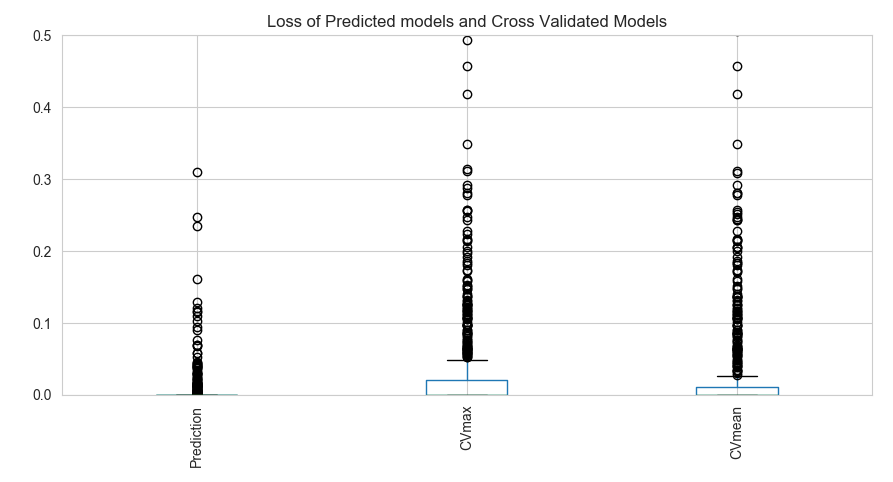

Prediction    0.030176
Name: 0.95, dtype: float64

In [21]:
loss_chart = loss_compare[['Prediction', 'CVmax', 'CVmean']].boxplot(rot=90)
loss_chart.set_title('Loss of Predicted models and Cross Validated Models')
loss_chart.set_ylim([0,0.5])
plt.tight_layout()
loss_prediction.quantile(q=0.95)

In [22]:
loss_compare.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction,CVmax,CVmean
count,678.000000,678.000000,678.000000,678.000000,678.000000,6.780000e+02,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000,678.000000
mean,0.267183,0.225904,0.306240,0.191057,0.174712,5.617788e-01,1.605107,21.219320,4.216537,0.204443,0.191080,0.338173,0.624650,0.005332,0.164456,0.153362
std,0.275666,0.261733,0.284260,0.258488,0.259986,1.431100e+00,8.344799,87.224387,6.290506,0.263773,0.265815,0.373415,0.529083,0.023795,0.941362,0.858915
min,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000e+00,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000,-0.000000
25%,0.077765,0.054629,0.111140,0.024853,0.001531,1.055655e-08,0.000665,0.021090,0.348011,0.033109,0.017421,0.054694,0.130453,-0.000000,-0.000000,-0.000000
50%,0.182912,0.151109,0.223079,0.085740,0.059739,3.888264e-02,0.031001,0.136229,1.112940,0.099324,0.081637,0.159144,0.677362,-0.000000,-0.000000,-0.000000
75%,0.347041,0.288029,0.403665,0.261021,0.250715,1.721460e-01,0.235047,1.963716,4.727335,0.286944,0.276656,0.586919,0.931339,-0.000000,0.020059,0.010919
max,1.568021,1.536364,1.462549,1.451289,1.455524,1.167758e+01,107.708968,640.144337,38.465977,1.481135,1.501381,3.395339,2.657132,0.310459,11.061203,10.175130


## Feature Importances

In [23]:
importances = selector.feature_importances_
std = np.std([tree.feature_importances_ for tree in selector.estimators_],
             axis=0)
feat_importance = pd.DataFrame(np.vstack((importances, std)), columns=features.columns, index=['mean', 'std'])

/home/rishi/.virtualenvs/ModelSelector/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: by argument to sort_index is deprecated, please use .sort_values(by=...)
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


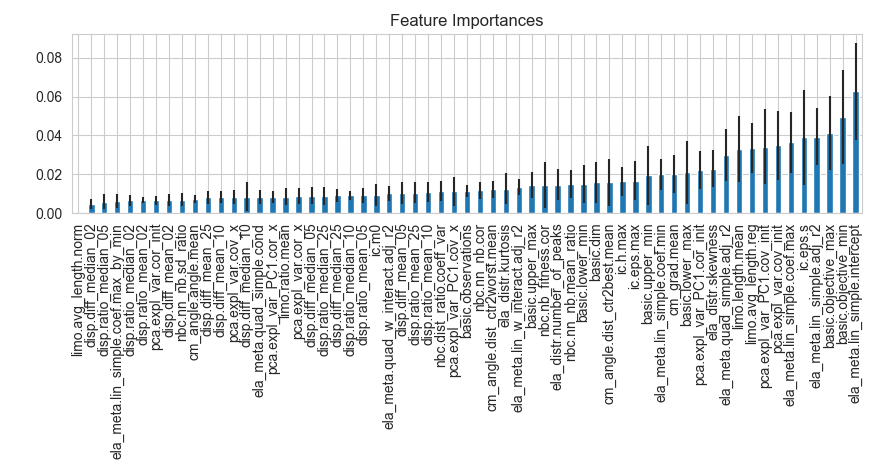

In [24]:
feat_importance.sort_index(by=['mean'], axis=1, inplace=True)
fig = feat_importance.loc['mean'].plot.bar(yerr=feat_importance.loc['std'])
plt.title('Feature Importances')
plt.tight_layout()

In [25]:
engineering_features = pd.read_csv("./features/engineering.csv", index_col=0)
engineering_features = engineering_features[features.columns]
engineering_features = engineering_features.dropna()

In [26]:
engineering_R2 = pd.read_csv('./surrogate_performance/engineeringR^2.csv', index_col=0)
# Calculating Loss and Targets. Target is the modelling method with lowest loss.
engineering_loss = -engineering_R2.sub(engineering_R2.max(axis=1), axis=0)
engineering_targets = engineering_loss.idxmin(axis=1)
# Getting data that is avalable in both targets and features
features_available_for = engineering_targets.index.intersection(engineering_features.index)
engineering_targets = engineering_targets.loc[features_available_for]
engineering_loss = engineering_loss.loc[features_available_for]

<IPython.core.display.Javascript object>


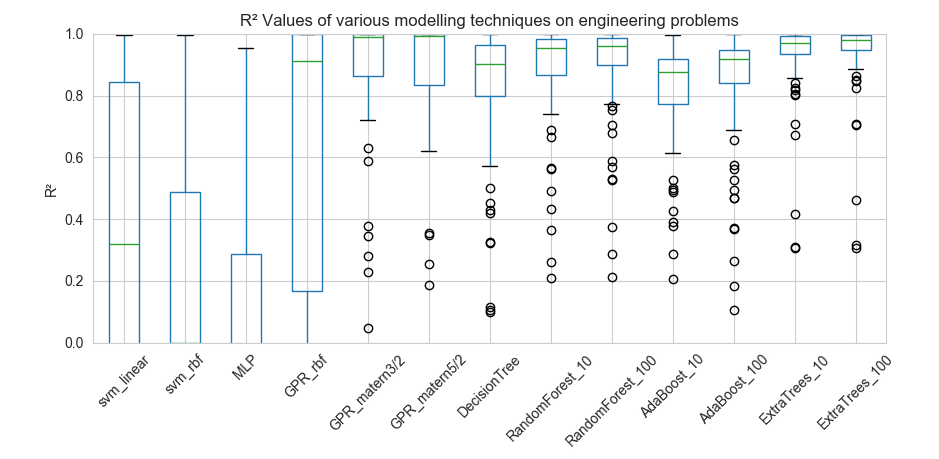

In [27]:
engineering_R2.plot.box(rot=45)
plt.ylim([0,1])
plt.ylabel('R²')
plt.title('R² Values of various modelling techniques on engineering problems')
plt.tight_layout()

In [28]:
selector = ExTC(n_estimators=10)
selector.fit(features.values, targets.values)
engineering_predictions = selector.predict(engineering_features)
engineering_predictions = pd.DataFrame(engineering_predictions, index=engineering_features.index, columns=['Prediction'])

In [29]:
metrics.confusion_matrix(engineering_targets, engineering_predictions)

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  0,  0,  0,  0,  0],
       [ 2,  4, 10,  1,  0,  1,  0, 11,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  2,  6,  1,  0,  4, 12],
       [ 1,  0,  3,  1,  3,  3,  0,  7,  0],
       [ 0,  0,  3,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0]])

In [30]:
engineering_loss_prediction = pd.DataFrame(columns=['Prediction'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_prediction['Prediction'].at[comp_id] = engineering_loss[engineering_predictions.loc[comp_id]].loc[comp_id]

In [31]:
engineering_loss.sort_index(axis=1, inplace=True)
engineering_loss = engineering_loss.join(engineering_loss_prediction)

## Cross Validation data

In [32]:
cv_scores_mean = pd.read_csv("./surrogate_performance/engineeringCV-score-mean.csv", index_col=0)
cv_scores_mean = cv_scores_mean.loc[features_available_for]
cv_scores_max = pd.read_csv("./surrogate_performance/engineeringCV-score-max.csv", index_col=0)
cv_scores_max = cv_scores_max.loc[features_available_for]

In [33]:
cv_mean_best = cv_scores_mean.idxmax(axis=1)
cv_max_best = cv_scores_max.idxmax(axis=1)

In [34]:
metrics.confusion_matrix(engineering_targets, cv_mean_best)

array([[ 0,  1,  0,  0,  0,  0],
       [ 0, 26,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0],
       [ 0,  1,  2, 20,  3,  0],
       [ 0,  0,  0,  2, 16,  0],
       [ 0,  0,  2,  1,  0,  0]])

In [35]:
metrics.confusion_matrix(engineering_targets, cv_max_best)

array([[ 0,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 26,  2,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  3, 22,  1,  0],
       [ 0,  0,  0,  0,  5, 13,  0],
       [ 0,  0,  0,  2,  1,  0,  0]])

In [36]:
engineering_loss_predictionCVmax = pd.DataFrame(columns=['PredictionCVmax'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmax['PredictionCVmax'].at[comp_id] = engineering_loss[cv_max_best.loc[comp_id]].loc[comp_id]

    
engineering_loss_predictionCVmean = pd.DataFrame(columns=['PredictionCVmean'], index=engineering_features.index, dtype=float)
for comp_id in engineering_features.index:
    engineering_loss_predictionCVmean['PredictionCVmean'].at[comp_id] = engineering_loss[cv_mean_best.loc[comp_id]].loc[comp_id]

In [37]:
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmax)
engineering_loss = engineering_loss.join(engineering_loss_predictionCVmean)

## Plots

<IPython.core.display.Javascript object>


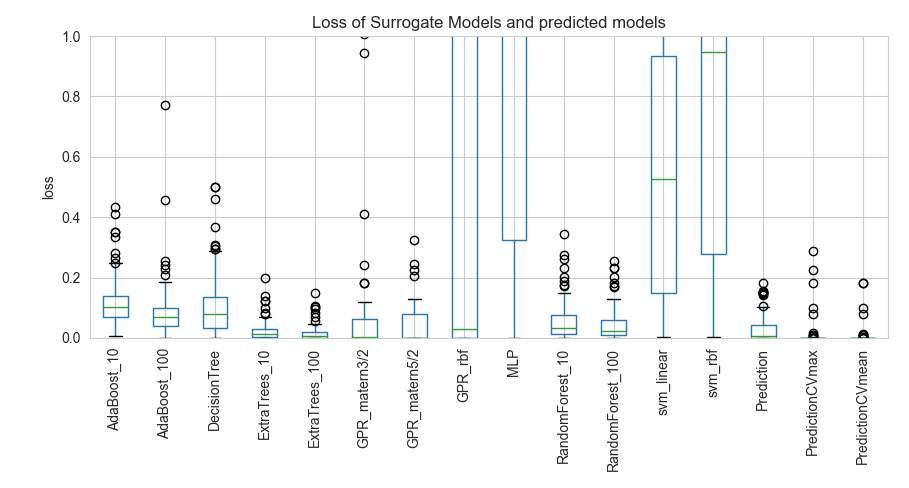

In [38]:
engg_loss_chart = engineering_loss.boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
plt.ylabel('loss')
engg_loss_chart.set_ylim([0,1])
plt.tight_layout()
engg_loss_chart

<IPython.core.display.Javascript object>


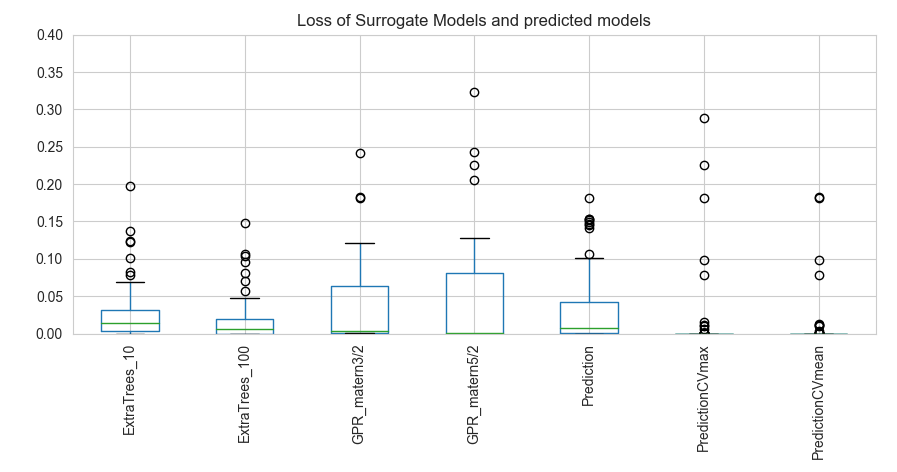

In [39]:
engg_loss_chart = engineering_loss[['ExtraTrees_10','ExtraTrees_100', 'GPR_matern3/2','GPR_matern5/2', 'Prediction', 'PredictionCVmax', 'PredictionCVmean']].boxplot(rot=90)
engg_loss_chart.set_title('Loss of Surrogate Models and predicted models')
engg_loss_chart.set_ylim([0,0.4])
plt.tight_layout()
engg_loss_chart

In [40]:
engineering_loss.describe()

,AdaBoost_10,AdaBoost_100,DecisionTree,ExtraTrees_10,ExtraTrees_100,GPR_matern3/2,GPR_matern5/2,GPR_rbf,MLP,RandomForest_10,RandomForest_100,svm_linear,svm_rbf,Prediction,PredictionCVmax,PredictionCVmean
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,0.119753,0.100426,0.111450,0.026402,0.016720,0.151598,0.176945,32.971680,66.272585,0.058712,0.048652,0.531101,0.703219,0.031937,0.011911,0.007711
std,0.095361,0.152892,0.116977,0.036064,0.028565,0.406823,0.490960,111.351412,220.510202,0.071614,0.060653,0.398577,0.436696,0.048609,0.047667,0.032145
min,0.005125,0.001085,0.000036,-0.000000,-0.000000,0.000002,-0.000000,-0.000000,-0.000000,0.000016,0.000010,0.002114,0.002207,-0.000000,-0.000000,-0.000000
25%,0.067919,0.039794,0.034042,0.003758,-0.000000,0.000107,-0.000000,0.000031,0.323454,0.013309,0.009045,0.149653,0.279390,0.000006,-0.000000,-0.000000
50%,0.101976,0.067813,0.079759,0.013654,0.005676,0.003260,0.000050,0.028301,3.723865,0.033138,0.024081,0.525263,0.948181,0.007568,-0.000000,-0.000000
75%,0.140208,0.099816,0.136860,0.030999,0.019397,0.063207,0.080757,1.547610,26.708943,0.074922,0.060918,0.932190,1.038348,0.042473,-0.000000,-0.000000
max,0.432549,1.053990,0.501111,0.197298,0.148233,2.214465,2.702947,413.478576,1259.316729,0.345750,0.256170,1.237660,1.306356,0.182093,0.288367,0.183104


In [41]:
engineering_loss.median()

AdaBoost_10         0.101976
AdaBoost_100        0.067813
DecisionTree        0.079759
ExtraTrees_10       0.013654
ExtraTrees_100      0.005676
GPR_matern3/2       0.003260
GPR_matern5/2       0.000050
GPR_rbf             0.028301
MLP                 3.723865
RandomForest_10     0.033138
RandomForest_100    0.024081
svm_linear          0.525263
svm_rbf             0.948181
Prediction          0.007568
PredictionCVmax     0.000000
PredictionCVmean    0.000000
dtype: float64